In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('archive/daily/AALI.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])  # Close price is the target
    return np.array(sequences), np.array(targets)


In [7]:
seq_length = 60
sequences, targets = create_sequences(scaled_data, seq_length)

In [8]:
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

In [9]:
model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(seq_length, 5)),
    Dropout(0.2),
    SimpleRNN(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

f:\KULIAH\SEM 4\MachineLearning\FinalProject\myvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,901 (30.86 KB)

 Trainable params: 7,901 (30.86 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.1117 - val_loss: 0.0018
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0162 - val_loss: 0.0017
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0089 - val_loss: 1.8498e-04
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0060 - val_loss: 1.4640e-04
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0046 - val_loss: 1.3946e-04
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0039 - val_loss: 3.1656e-04
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0031 - val_loss: 1.1437e-04
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0028 - val_loss: 9.7753e-05
Epoch 9/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0025 - val_loss: 9.9256e-05
Epoch 10/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0022 - val_loss: 1.3786e-04


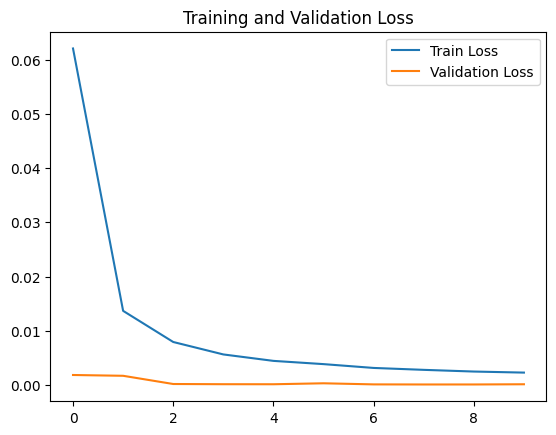

In [12]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [13]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [14]:
combined_train_test_predictions = np.concatenate((train_predictions, test_predictions), axis=0)
combined_train_test_actual = np.concatenate((y_train, y_test), axis=0)

In [15]:
mse_normalized = mean_squared_error(combined_train_test_actual, combined_train_test_predictions)
mape_normalized = mean_absolute_percentage_error(combined_train_test_actual, combined_train_test_predictions)
r2_normalized = r2_score(combined_train_test_actual, combined_train_test_predictions)

print(f'Normalized Data Metrics:')
print(f'MSE: {mse_normalized}')
print(f'MAPE: {mape_normalized}')
print(f'R2 Score: {r2_normalized}')

Normalized Data Metrics:
MSE: 0.0002469484172082768
MAPE: 0.045503350482897206
R2 Score: 0.995544535197413


In [16]:
def inverse_transform_predictions(predictions, data_scaler, index=3):
    dummy_data = np.zeros((predictions.shape[0], data_scaler.n_features_in_))
    dummy_data[:, index] = predictions[:, 0] 
    return data_scaler.inverse_transform(dummy_data)[:, index]

train_predictions_denormalized = inverse_transform_predictions(train_predictions, scaler)
test_predictions_denormalized = inverse_transform_predictions(test_predictions, scaler)

In [17]:
y_train_denormalized = inverse_transform_predictions(y_train.reshape(-1, 1), scaler)
y_test_denormalized = inverse_transform_predictions(y_test.reshape(-1, 1), scaler)

In [18]:
mse_denormalized = mean_squared_error(y_test_denormalized, test_predictions_denormalized)
mape_denormalized = mean_absolute_percentage_error(y_test_denormalized, test_predictions_denormalized)
r2_denormalized = r2_score(y_test_denormalized, test_predictions_denormalized)

print(f'Denormalized Data Metrics:')
print(f'MSE: {mse_denormalized}')
print(f'MAPE: {mape_denormalized}')
print(f'R2 Score: {r2_denormalized}')

Denormalized Data Metrics:
MSE: 140671.4651686549
MAPE: 0.028087887785909076
R2 Score: 0.9578900258978369


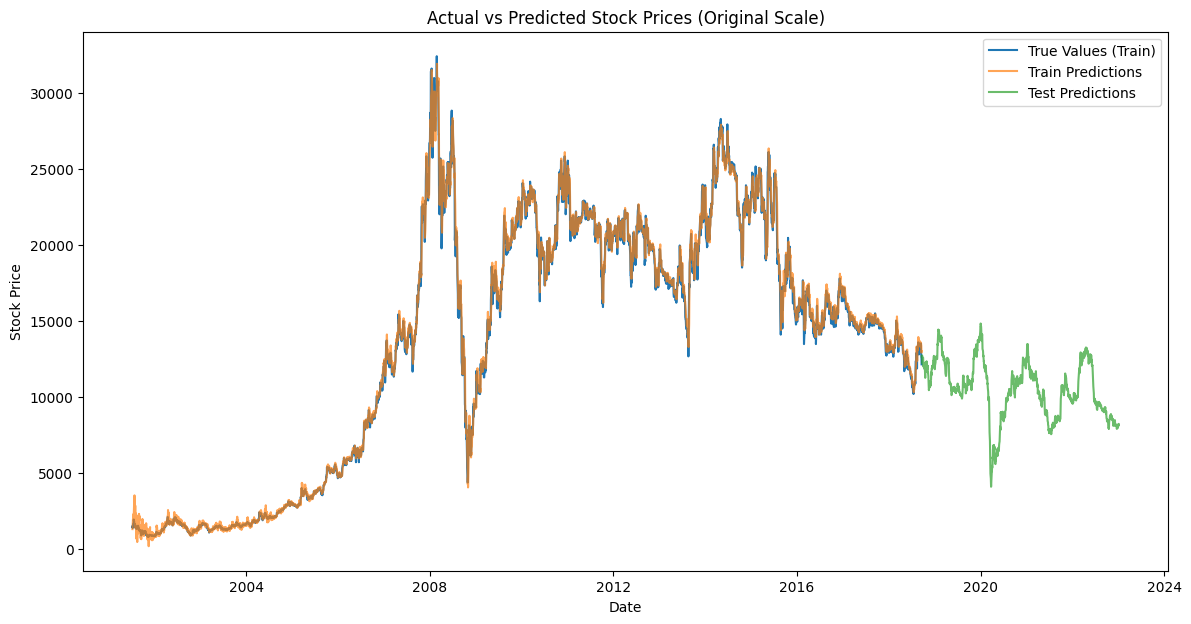

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[seq_length:seq_length+len(y_train_denormalized)], y_train_denormalized, label='True Values (Train)')
plt.plot(data.index[seq_length:seq_length+len(train_predictions_denormalized)], train_predictions_denormalized, label='Train Predictions', alpha=0.7)
plt.plot(data.index[seq_length+len(train_predictions_denormalized):seq_length+len(train_predictions_denormalized)+len(test_predictions_denormalized)], test_predictions_denormalized, label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

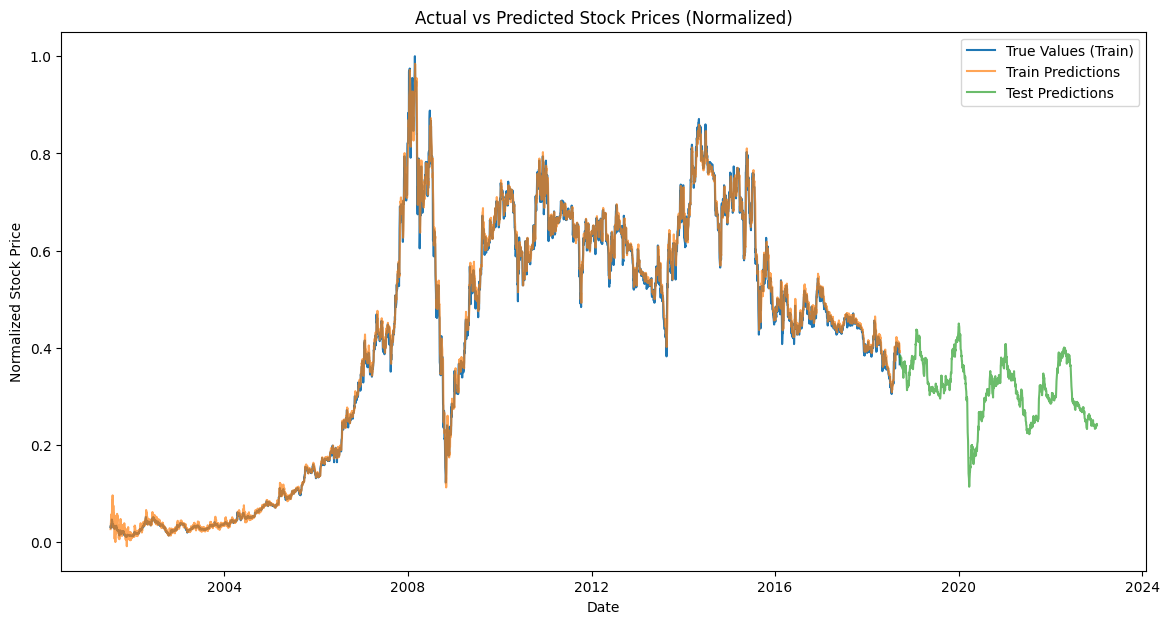

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[seq_length:seq_length + len(y_train)], y_train, label='True Values (Train)')
plt.plot(data.index[seq_length:seq_length + len(train_predictions)], combined_train_test_predictions[:len(train_predictions)], label='Train Predictions', alpha=0.7)
plt.plot(data.index[seq_length + len(train_predictions):seq_length + len(train_predictions) + len(test_predictions)], combined_train_test_predictions[len(train_predictions):], label='Test Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Normalized)')
plt.xlabel('Date')
plt.ylabel('Normalized Stock Price')
plt.show()